In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost as xgb
import pickle

In [2]:
def splitData():
    df_train_neg = df_train.loc[df_train['isFraud'] == 0]
    df_train_pos = df_train.loc[df_train['isFraud'] == 1]
    
    split = 0.2
    x_train_pos, x_val_pos = train_test_split(df_train_pos, test_size=split, random_state=42)
    x_train_neg, x_val_neg = train_test_split(df_train_neg, test_size=split, random_state=42)
    
    #downsample the majority to achieve 1:1 class distribution
    x_train_neg = x_train_neg.sample(frac=1/27)
    x_val_neg   = x_val_neg.sample(frac=1/27)
    
    #combine and reshuffle training and validation sets
    x_train = (x_train_pos.append(x_train_neg)).sample(frac=1)
    x_val   = (x_val_pos.append(x_val_neg)).sample(frac=1)
    
    y_train = x_train.pop('isFraud')
    y_val   = x_val.pop('isFraud')
    
    return x_train, x_val, y_train, y_val

In [3]:
# array of tuples: train and test in each tuple.
with open('df_test_cleaned.pickle','rb') as f:
    df_test = pickle.load(f)
with open('df_train_cleaned.pickle','rb') as g:
    df_train = pickle.load(g)
with open('df_test_transactionids.pickle','rb') as h:
    df_test_transactionids = pickle.load(h)

In [4]:
X_train, X_test, y_train, y_test = splitData()

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))   

In [5]:
clf = xgb.XGBClassifier(n_estimators=500,
                        n_jobs=4,
                        max_depth=9,
                        learning_rate=0.05,
                        subsample=0.9,
                        colsample_bytree=0.9,
                        missing=-999)

clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=-999, n_estimators=500, n_jobs=4,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9, verbosity=1)

[[3787  434]
 [ 590 3543]]
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      4221
           1       0.89      0.86      0.87      4133

   micro avg       0.88      0.88      0.88      8354
   macro avg       0.88      0.88      0.88      8354
weighted avg       0.88      0.88      0.88      8354



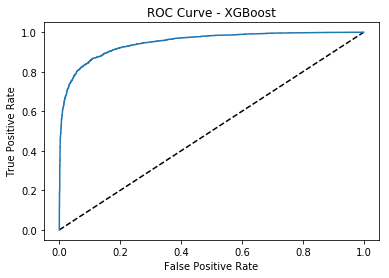

AUC: 0.9480743426072431
AUC scores computed using 5-fold cross-validation: [0.88519137 0.92613367 0.92046631 0.93711828 0.9111496 ]


In [8]:
        # P R E D I C T
        # Predict the labels of the test set: y_pred
        y_pred = clf.predict(X_test)
        #
        # E V A L U A T E
        #
        # Compute and print the confusion matrix and classification report
        print(confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))

        # R O C 
        # Compute predicted probabilities: y_pred_prob
        y_pred_prob = clf.predict_proba(X_test)[:,1]

        # Generate ROC curve values: fpr, tpr, thresholds
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

        # Plot ROC curve
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - XGBoost')
        plt.show()        
        
        # Compute and print AUC score
        print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

        # Compute cross-validated AUC scores: cv_auc
        X = df_train.drop('isFraud',axis=1)
        y = df_train['isFraud']
        cv_auc = cross_val_score(clf,X,y,scoring='roc_auc',cv=5)
        # Print list of AUC scores
        print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))
        
        y_real_pred = clf.predict_proba(df_test)[:,1]
        results_dict = dict(zip(df_test_transactionids.to_list(),y_real_pred))
        items = results_dict.items()
        results_df = pd.DataFrame({'TransactionID': [i[0] for i in items], 'isFraud': [i[1] for i in items]})
        csv_name = 'results_xgboost.csv'
        results_df.to_csv(csv_name,index=False)


sample_submission['isFraud'] = clf.predict_proba(X_test)[:,1]
sample_submission.to_csv('simple_xgboost.csv')